In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]


In [2]:
def plot_pred_peak_timing(peaks):
    set_seaborn_style()
    # Melt the dataframe to long format for easier plotting with seaborn
    melted_df = peaks.melt(id_vars="condition", var_name="Operation", value_name="Time")
    melted_df["Time"] = (melted_df["Time"] / 250)  # Convert to seconds

    # Create the boxplots
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=melted_df, x="Operation", y="Time", hue="condition")
    plt.xlabel("Operation")
    plt.ylabel("Absolute timing (seconds)")
    plt.ylim(0, 1.0)
    plt.legend(title="Condition")
    plt.tight_layout()
    plt.show()

def plot_pred_peak_timing_since_previous(peaks):
    set_seaborn_style()
    # Melt the dataframe to long format for easier plotting with seaborn
    peaks = peaks.copy()
    for i in range(len(peaks.columns) - 1, 1, -1):
        peaks.iloc[:, i] = peaks.iloc[:, i] - peaks.iloc[:, i - 1]
    mean_df = peaks.groupby("condition").mean().reset_index()
    mean_df.iloc[:,1:] = mean_df.iloc[:,1:] / 250
    print(mean_df)
    melted_df = peaks.melt(id_vars="condition", var_name="Operation", value_name="Time")
    melted_df["Time"] = (melted_df["Time"] / 250)  # Convert to seconds
    # Create the boxplots
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=melted_df, x="Operation", y="Time", hue="condition")
    plt.xlabel("Operation")
    plt.ylabel("Time since last event (seconds)")
    # plt.ylim(0, 1.0)
    plt.legend(title="Condition")
    plt.tight_layout()
    plt.show()

def plot_pred_vs_true_peak_timing(labels, ax_long, ax_short, path: Path, cue_var="condition", sample=True):
    df = pd.read_csv(path)
    set_seaborn_style()
    for i_label, label in enumerate(labels):
        if label == "negative":
            continue
        df[f"{label}_pred"] /= df["rt_samples"]
        df[f"{label}_true"] /= df["rt_samples"]

        scatter_subset = df[df[cue_var] == 'long']
        if sample:
            scatter_subset = scatter_subset.sample(frac=0.1)
        sns.scatterplot(
            scatter_subset,
            x=f"{label}_pred",
            y=f"{label}_true",
            alpha=0.1,
            ax=ax_long,
            color=sns.color_palette()[i_label - 1],
            linewidth=0,
        )

        scatter_subset = df[df[cue_var] == 'short']
        if sample:
            scatter_subset = scatter_subset.sample(frac=0.1)
        sns.scatterplot(
            scatter_subset,
            x=f"{label}_pred",
            y=f"{label}_true",
            alpha=0.1,
            ax=ax_short,
            color=sns.color_palette()[i_label - 1],
            linewidth=0,
        )

def save_peak_timing(model, loader, labels, path: Path, cue_var="condition"):
    if not path.exists():
        output = []
        torch.cuda.empty_cache()

        with torch.no_grad():
            for batch in loader:
                info = batch[2][0]  # Contains RT

                pred = model(batch[0].to(DEVICE))
                pred = torch.nn.Softmax(dim=2)(pred).to("cpu")

                true = batch[1]

                lengths = get_masking_indices(batch[0])

                pred_peaks = pred[..., 1:].argmax(dim=1).float()
                true_peaks = true[..., 1:].argmax(dim=1).float()

                # Get activations at the peak positions
                batch_indices = torch.arange(batch[0].shape[0]).unsqueeze(1).expand(-1, pred_peaks.shape[-1])
                # [batch_size, classes, channels]
                peak_values = batch[0][batch_indices, pred_peaks.int(), :]

                # pred_peaks /= lengths.unsqueeze(1)
                # true_peaks /= lengths.unsqueeze(1)
                data = {"condition": info[cue_var], "epoch": info["trial_index"], "participant": info["participant"], "rt_samples": lengths}
                for i, label in enumerate(labels):
                    if i == 0:
                        continue
                    label_pred_peaks = pred_peaks[:, i - 1]
                    label_true_peaks = true_peaks[:, i - 1]
                    data[f"{label}_pred"] = label_pred_peaks
                    data[f"{label}_true"] = label_true_peaks
                    data[f"{label}_peak_values"] = peak_values[:, i - 1].tolist()
                output.append(data)
        df = pd.concat([pd.DataFrame(data) for data in output])
        df.to_csv(path, index=False)
    else:
        df = pd.read_csv(path)

def plot_peak_topos(path: Path, labels, positions, conditions, cue_var="condition"):
    df = pd.read_csv(path)
    set_seaborn_style()
    fig, axs = plt.subplots(2, len(labels) - 1, figsize=(6, 4))
    for i_cond, condition in enumerate(conditions):
        cur_df = df[df[cue_var] == condition]
        axs[i_cond, 0].set_ylabel(condition)
        for i, label in enumerate(labels):
            if label == "negative":
                continue
            # Get the peak values for the current label
            # Convert list value to numpy array
            peak_values = cur_df[f"{label}_peak_values"].apply(eval)
            peak_values = np.array([np.array(x) for x in peak_values]).mean(axis=0)[:64]
            mne.viz.plot_topomap(peak_values, positions, axes=axs[i_cond, i - 1], show=False, cmap='Spectral_r', vlim=(-2, 2))
            if i_cond == 0:
                axs[i_cond, i - 1].set_title(label)
    fig.supylabel("Condition")
    fig.suptitle("Operation")
    fig.tight_layout()
    return fig

def plot_diff_topos_within_task(path: Path, label, positions, conditions, cue_var="condition"):
    df = pd.read_csv(path)
    set_seaborn_style()
    fig, axs = plt.subplots(3, 1, figsize=(6, 4))
    peak_values_coll = []
    for i_cond, condition in enumerate(conditions):
        cur_df = df[df[cue_var] == condition]
        axs[i_cond].set_ylabel(condition)
        peak_values = cur_df[f"{label}_peak_values"].apply(eval)
        peak_values = np.array([np.array(x) for x in peak_values]).mean(axis=0)[:64]
        peak_values_coll.append(peak_values)
        mne.viz.plot_topomap(peak_values, positions, axes=axs[i_cond], show=False, cmap='Spectral_r', vlim=(-2, 2))
    # Calculate the difference between the two conditions
    diff = peak_values_coll[0] - peak_values_coll[1]
    mne.viz.plot_topomap(diff, positions, axes=axs[2], show=False, cmap='Spectral_r', vlim=(-2, 2))
    axs[2].set_ylabel("diff")
    fig.tight_layout()
    return fig

### Analysis task 1

In [ ]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t1.nc"]

# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = split_participants_custom(data_paths, 0)
# info_to_keep = ['event_name', 'participant', 'epochs', 'rt'] #TODO: Might not be present
info_to_keep = ['rt', 'participant', 'epochs', 'condition', 'trial_index']
whole_epoch = True
subset_cond = None
# subset_cond = ('condition', 'equal', 'long')
add_negative = True
skip_samples = 62 # 62
cut_samples = 63 # 63
add_pe = True

In [ ]:
norm_fn = norm_mad_zscore
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    labels=labels_t1,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [ ]:
test_loader = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [ ]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

In [ ]:
chk_path = Path("../models/t1_pe.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 64,
    "n_classes": len(labels_t1),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}

model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [ ]:
save_peak_timing(model, test_loader, labels_t1, Path("files/t1_peaks.csv"), cue_var="condition")

In [ ]:
fig = plot_peak_topos(Path("files/t1_peaks.csv"), labels_t1, positions, conditions=['long', 'short'], cue_var="condition")
fig.show()

In [ ]:
fig = plot_diff_topos_within_task(Path("files/t1_peaks.csv"), "t1_3", positions, conditions=['long', 'short'], cue_var="condition")
fig.show()

In [ ]:
# select columns including 'condition', 'pred', or 'true'
t1_df = pd.read_csv(Path("files/t1_peaks.csv"))
t1_df = t1_df.loc[:, t1_df.columns.str.contains('condition|pred')]
mean_df = t1_df.groupby("condition").mean().reset_index()
mean_df[["t1_1_pred", "t1_2_pred", "t1_3_pred"]] = mean_df[["t1_1_pred", "t1_2_pred", "t1_3_pred"]] / 250
mean_df
# At how many seconds is the peak generally seen?

In [ ]:
plot_pred_peak_timing(t1_df)

In [ ]:
plot_pred_peak_timing_since_previous(t1_df)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
set_seaborn_style()
plot_pred_vs_true_peak_timing(labels_t1, axs[0], axs[1], path=Path("files/t1_peaks.csv"), sample=False)
axs[0].set_ylabel("True peak timing (normalized)")
axs[0].set_xlabel("Predicted peak timing (normalized)")
axs[1].set_ylabel("")
axs[1].set_xlabel("Predicted peak timing (normalized)")
axs[0].set_title("Long SOA")
axs[1].set_title("Short SOA")
fig.show()

### Analysis Task 2

In [ ]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]

# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = split_participants_custom(data_paths, 0)
# info_to_keep = ['event_name', 'participant', 'epochs', 'rt'] #TODO: Might not be present
info_to_keep = ['rt', 'participant', 'epochs', 'condition', 'trial_index']
whole_epoch = True
subset_cond = None
# subset_cond = ('condition', 'equal', 'long')
add_negative = True
skip_samples = 62 # 62
cut_samples = 63 # 63
add_pe = True

In [ ]:
norm_fn = norm_mad_zscore
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    labels=labels_t2,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [ ]:
test_loader = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [ ]:
chk_path = Path("../models/t2_pe.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 64,
    "n_classes": len(labels_t2),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}

model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [ ]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

In [ ]:
save_peak_timing(model, test_loader, labels_t2, Path("files/t2_peaks.csv"), cue_var="condition")

In [ ]:
fig = plot_peak_topos(Path("files/t2_peaks.csv"), labels_t2, positions, conditions=['long', 'short'], cue_var="condition")
fig.show()

In [ ]:
# select columns including 'condition', 'pred', or 'true'
t2_df = pd.read_csv(Path("files/t2_peaks.csv"))
t2_df = t2_df.loc[:, t2_df.columns.str.contains('condition|pred')]
mean_df = t2_df.groupby("condition").mean().reset_index()
mean_df[["t2_1_pred", "t2_2_pred", "t2_3_pred"]] = mean_df[["t2_1_pred", "t2_2_pred", "t2_3_pred"]] / 250
mean_df
# At how many seconds is the peak generally seen?

In [ ]:
plot_pred_peak_timing(t2_df)

In [ ]:
plot_pred_peak_timing_since_previous(t2_df)

In [ ]:
import scipy.stats as stats

def calc_stats(df, operation="t2_3"):
    # Subset and convert to seconds
    df_long = df[df["condition"] == "long"][operation].to_numpy()
    df_short = df[df["condition"] == "short"][operation].to_numpy()

    stat, p = stats.mannwhitneyu(df_long, df_short)
    print(f'Operation: {operation}, U-statistic: {stat}, p-value: {p}')
    
for operation in t2_df.keys()[1:]:
    calc_stats(t2_df, operation=operation)
for operation in t1_df.keys()[1:]:
    calc_stats(t1_df, operation=operation)

### Combined tasks

In [98]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2"))
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]
    # Approximate, since timing isn't EXACTLY 300ms/1200ms
    # Add ISI to task 2 predictions to get absolute time
    df.loc[df['condition'] == 'short', pred_cols_t2] += 0.277344 * 250
    df.loc[df['condition'] == 'long', pred_cols_t2] += 1.177734 * 250

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]
    return df


In [99]:
paths = [Path("files/t1_peaks.csv"), Path("files/t2_peaks.csv")]
labels = [labels_t1, labels_t2]
df = determine_order(paths, labels)

In [121]:
def plot_timing_effect_on_rt(df, event_idx, task="t1"):
    threshold = 50
    event_idx = f"event_{event_idx}_idx"

    event_counts = df.groupby(["condition", event_idx]).size().reset_index(name="count")
    valid_pairs = event_counts[event_counts["count"] > threshold]
    df = df.merge(
        valid_pairs[["condition", event_idx]],
        on=["condition", event_idx],
        how="inner",  # Keep only rows that match valid (condition, event) pairs
    )
    df[f"rt_samples_{task}"] = (df[f"rt_samples_{task}"] / 250) * 1000
    sns.violinplot(data=df, x=event_idx, y=f"rt_samples_{task}", hue="condition")
    plt.xlabel(f"Event at position {event_idx} in time")
    plt.ylabel(f"RT {task} (ms)")
    plt.show()


def plot_order_effect_on_rt(df, orders: list[list[int]], labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]):
    set_seaborn_style()
    event_cols = [col for col in df.columns if col.startswith("event_")]
    df = df.copy()
    df["order_idx"] = -1  # Initialize with -1 for rows that don't match any order
    df = df[df["condition"] == "short"]
    for idx, order in enumerate(orders):
        # Compare order of events with order in dataframe
        mask = (
            (df[event_cols[0]] == order[0])
            & (df[event_cols[1]] == order[1])
            & (df[event_cols[2]] == order[2])
            & (df[event_cols[3]] == order[3])
            & (df[event_cols[4]] == order[4])
            & (df[event_cols[5]] == order[5])
        )
        df.loc[mask, "order_idx"] = idx
    # Filter out rows with order_idx -1
    df = df[df["order_idx"] != -1]
    df["rt_samples_t1"] = (df["rt_samples_t1"] / 250) * 1000
    sns.violinplot(data=df, x="order_idx", y="rt_samples_t1", cut=0)
    xticks = [' > '.join([labels[i] for i in order]) for order in orders]
    plt.xticks(range(len(orders)), xticks, rotation=45)
    plt.hlines(y=610.63, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[2], linestyles='dashed', label="Mean RT (short)")
    plt.hlines(y=599.84, xmin=-0.5, xmax=len(orders)-0.5, color=sns.color_palette()[1], linestyles='dashed', label="Mean RT (long)")
    plt.legend()
    plt.xlabel("Order of events")
    plt.ylabel("RT t1 (ms)")
    plt.ylim(200, 1000)
    plt.show()

In [108]:
df.groupby("condition")["rt_samples_t1"].mean().reset_index()["rt_samples_t1"] / 250 * 1000

0    599.848647
1    610.631863
Name: rt_samples_t1, dtype: float64

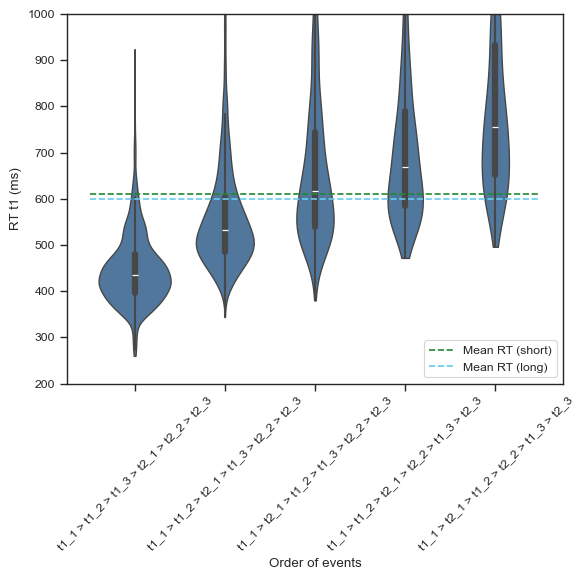

In [122]:
plot_order_effect_on_rt(df, [[0, 1, 2, 3, 4, 5], [0, 1, 3, 2, 4, 5], [0, 3, 1, 2, 4, 5], [0, 1, 3, 4, 2, 5], [0, 3, 1, 4, 2, 5]])

In [ ]:
df[df["event_3_idx"] == 4].iloc[0,:]
# t1_1 - 43, t2_1, 112, t1_2 - 150, t2_2 - 161, t1_3 - 191, t2_3 - 235
# THE event_n_idx N-TH EVENT is the INDEX IN LABELS

condition                                                       short
epoch                                                           481.0
participant                                                       VP5
rt_samples_t1                                                     196
t1_1_pred                                                        43.0
t1_1_true                                                        13.0
t1_1_peak_values    [0.8136295676231384, 0.18116751313209534, -0.1...
t1_2_pred                                                       150.0
t1_2_true                                                       158.0
t1_2_peak_values    [-2.080155372619629, -2.2829220294952393, -1.4...
t1_3_pred                                                       191.0
t1_3_true                                                       190.0
t1_3_peak_values    [-0.8969032764434814, -0.6788650155067444, -1....
rt_samples_t2                                                     180
t2_1_pred           

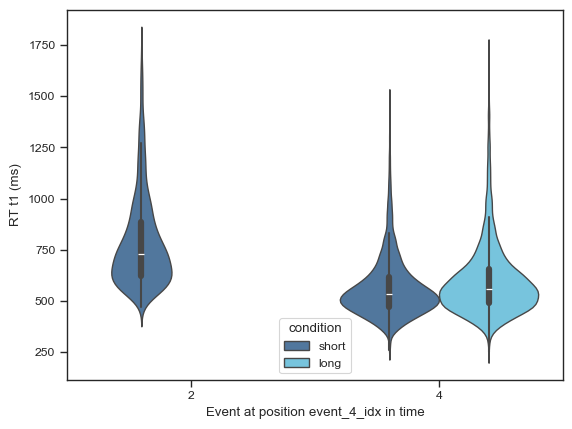

In [124]:
plot_timing_effect_on_rt(df, 4, task='t1')

In [39]:
def plot_order_distribution_stacked(df, labels, min_count=500):
    set_seaborn_style()
    # Count the occurrences of each order, grouped by condition
    order_columns = [f"event_{i}_idx" for i in range(len(labels))]
    df = df[["condition"] + order_columns]
    order_counts = (
        df.groupby(["condition"])
        .apply(lambda x: x[order_columns].apply(tuple, axis=1).value_counts())
        .reset_index(name="Count")
    )

    # Filter orders with more than min_count occurrences
    order_counts = order_counts[order_counts["Count"] > min_count]

    # Create a DataFrame for plotting
    order_df = pd.DataFrame(order_counts)
    order_df.columns = ["condition", "Order", "Count"]

    # Convert the Order tuples to strings for better readability
    order_df["Order"] = order_df["Order"].apply(lambda x: " > ".join([labels[i] for i in x]))

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Count", y="Order", hue="condition", data=order_df, dodge=False)
    plt.xlabel("Count")
    plt.ylabel("Order")
    plt.show()

/tmp/ipykernel_106616/544367489.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[order_columns].apply(tuple, axis=1).value_counts())


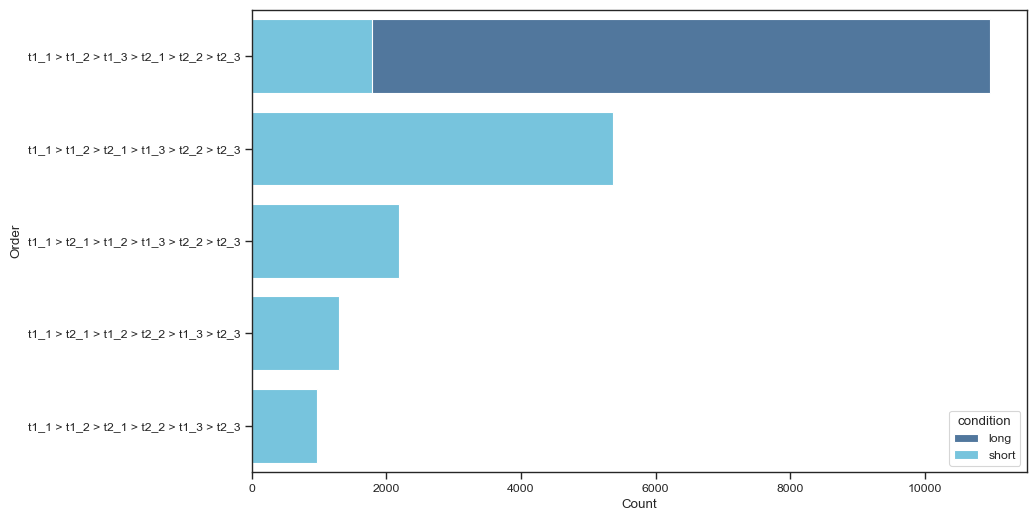

In [40]:
plot_order_distribution_stacked(df, ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], min_count=500)

In [353]:
def get_inter_event_timings(
    df: pd.DataFrame,
    event_1: str,
    event_2: str,
    event_disruptor: str = None,
    labels: list[str] = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"],
    condition: str = None,
    return_df: bool = False,
):
    # Calculate the time difference between two events
    if condition is not None:
        df = df[df["condition"] == condition]
    ev1_label = f"{event_1}_pred"
    ev2_label = f"{event_2}_pred"

    event_cols = [col for col in df.columns if col.startswith("event_")]
    event_sequences = df[event_cols].values.tolist()

    if event_disruptor is not None:
        target_sequence = [
            labels.index(event_1),
            labels.index(event_disruptor),
            labels.index(event_2),
        ]
        mask = [
            any(
                sequence[i : i + len(target_sequence)] == target_sequence
                for i in range(len(sequence) - len(target_sequence) + 1)
            )
            for sequence in event_sequences
        ]
        df = df[mask]
    else:
        # We know that the order is t1_1, t1_2, t1_3, t2_1, t2_2, t2_3
        # Only use timings between those two events (that are always sequential)
        # When the order is 'default'
        df = df[
            (df[event_cols[0]] == 0)
            & (df[event_cols[1]] == 1)
            & (df[event_cols[2]] == 2)
            & (df[event_cols[3]] == 3)
            & (df[event_cols[4]] == 4)
            & (df[event_cols[5]] == 5)
        ]

    if return_df:
        return df
    else:
        diffs = df[ev2_label] - df[ev1_label]
        df = df[["condition", "epoch", "participant"]]
        df["difference"] = (diffs / 250) * 1000  # Convert to milliseconds
        df["disrupted"] = 1 if event_disruptor is not None else 0
        return df

In [270]:
def plot_inter_event_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition='short')
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    df = pd.concat([no_disruption, with_disruption])
    sns.violinplot(data=df, x="disrupted", y="difference", split=False)
    plt.xticks([0, 1], ['Not disrupted', f'Disrupted by {event_disruptor}'])
    plt.ylabel(f"Time between {event_1} and {event_2} (samples)")
    # plt.xlabel(f"Time between {event_1} and {event_2} (samples)")
    plt.show()

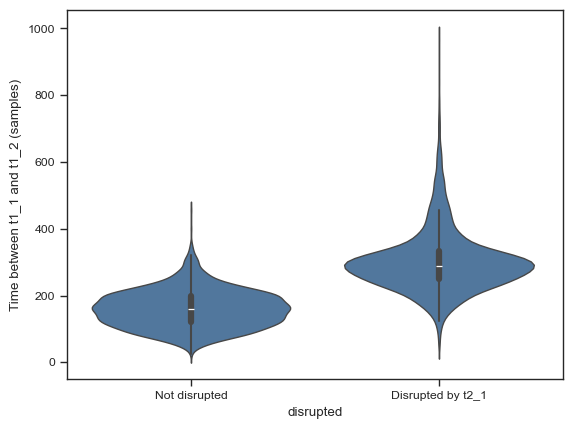

In [337]:
plot_inter_event_timings(df, "t1_1", "t1_2", "t2_1")

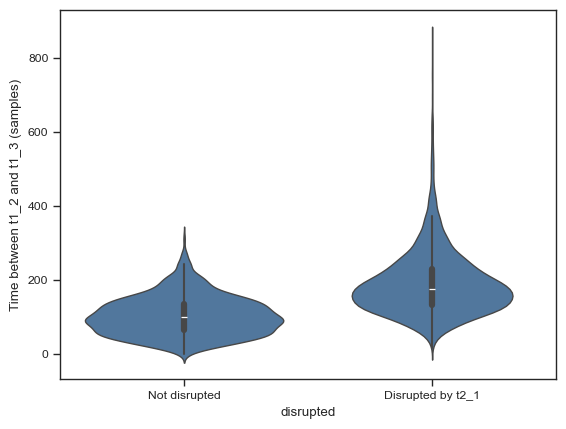

In [338]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_1")

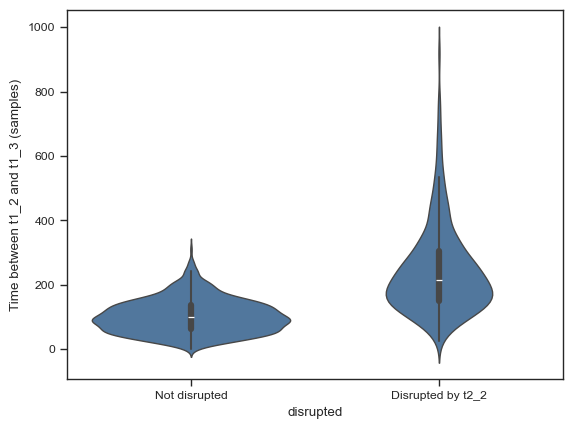

In [339]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_2")

In [ ]:
def get_disruptor_timings(df, event_1, event_2, event_disruptor, source='long', labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]):
    # How long event_1 > event_2 usually takes
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    
    # How long event_1 > event_2 takes when event_disruptor is present
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')

    # How long event_disruptor > next event usually takes 
    after_disruption = get_inter_event_timings(df, event_disruptor, labels[labels.index(event_disruptor) + 1], condition="long")
    after_disruption["disrupted"] = 2

    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption, after_disruption])
    return df

def plot_all_timings():
    results = []
    for event_1, event_2 in [
        ("t1_1", "t1_2"),
        ("t1_2", "t1_3"),
        ("t2_1", "t2_2"),
        ("t2_2", "t2_3"),
        # ("t1_3", "t2_1"),	
    ]:
        for source in ["long", "short"]:
            combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
            combination_results["sequence"] = f"{event_1} > {event_2}"
            results.append(combination_results)
    results = pd.concat(results)
    return results

In [ ]:
results = []
for event_1, event_2 in [
    ("t1_1", "t1_2"),
    ("t1_2", "t1_3"),
    ("t2_1", "t2_2"),
    ("t2_2", "t2_3"),
    ("t1_3", "t2_1"),	
]:
    for source in ["long", "short"]:
        combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
        combination_results["sequence"] = f"{event_1} > {event_2}"
        results.append(combination_results)
results = pd.concat(results)

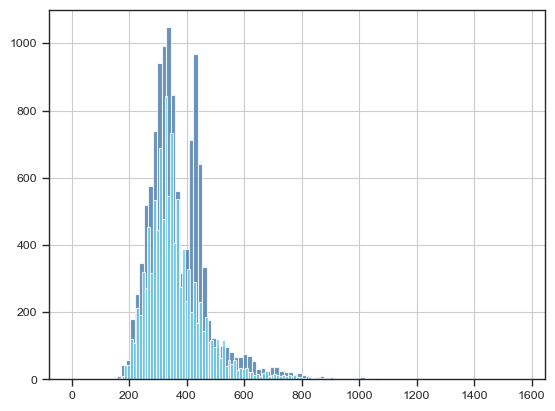

In [335]:
((df[df['condition'] == 'short']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8)
((df[df['condition'] == 'long']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8)
plt.show()

Disrupted sequences vs non-disrupted sequences, per unique disruption, uses only SHORT timings from default order

Found 3491 disruptions (cases where t1_1 > t2_1 > t1_2)
Found 5373 disruptions (cases where t1_2 > t2_1 > t1_3)
Found 1306 disruptions (cases where t1_2 > t2_2 > t1_3)
Found 5382 disruptions (cases where t2_1 > t1_3 > t2_2)
Found 2280 disruptions (cases where t2_2 > t1_3 > t2_3)


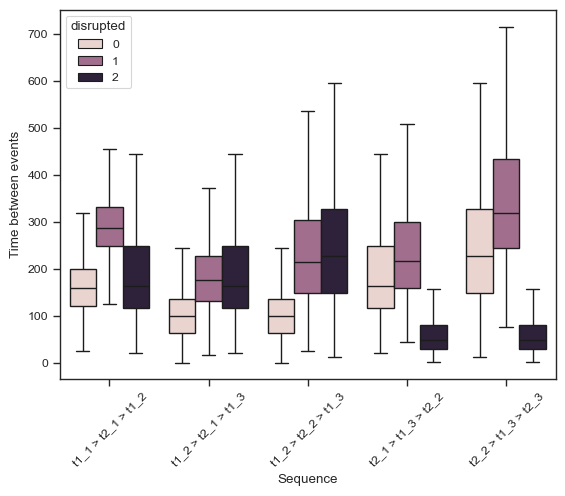

In [381]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    ("t1_2", "t1_3", "t2_1"),
    ("t1_2", "t1_3", "t2_2"),
    ("t2_1", "t2_2", "t1_3"),
    ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short")
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [383]:
for sequence in results["sequence"].unique():
    sequence_df = results[results["sequence"] == sequence]
    disr_0 = sequence_df[sequence_df["disrupted"] == 0]["difference"]
    disr_1 = sequence_df[sequence_df["disrupted"] == 1]["difference"]
    disr_2 = sequence_df[sequence_df["disrupted"] == 2]["difference"]

    n_boot = 10000
    boot_diffs = []
    for _ in range(n_boot):
        boot_0 = np.random.choice(disr_0, size=len(disr_0), replace=True).mean()
        boot_1 = np.random.choice(disr_1, size=len(disr_1), replace=True).mean()
        boot_2 = np.random.choice(disr_2, size=len(disr_2), replace=True).mean()
        diff = boot_2 - (boot_1 - boot_0)
        boot_diffs.append(diff)

    lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
    print(f"{sequence} 95% CI: [{lower:.2f}, {upper:.2f}]")
# How much bigger the difference between disruptor > next is than the difference between event 1 > event 2 with and without disruptor

t1_1 > t2_1 > t1_2 95% CI: [44.07, 57.13]
t1_2 > t2_1 > t1_3 95% CI: [98.76, 111.20]
t1_2 > t2_2 > t1_3 95% CI: [101.85, 122.57]
t2_1 > t1_3 > t2_2 95% CI: [2.55, 15.58]
t2_2 > t1_3 > t2_3 95% CI: [-46.34, -27.45]


In [ ]:
# If (t1_1 > t2_1 > t1_2), want to also know if increase is similar to t2_1 > t2_2
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    ("t1_2", "t1_3", "t2_1"),
    ("t1_2", "t1_3", "t2_2"),
    ("t2_1", "t2_2", "t1_3"),
    ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short")
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.violinplot(results, x="sequence", y="difference", hue="disrupted", cut=0)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

,condition,epoch,participant,difference,disrupted,sequence
2,short,49.0,VP14,156.0,False,t1_1 > t2_1 > t1_2
22,short,425.0,VP10,164.0,False,t1_1 > t2_1 > t1_2
30,short,849.0,VP17,220.0,False,t1_1 > t2_1 > t1_2
47,short,772.0,VP1,152.0,False,t1_1 > t2_1 > t1_2
52,short,1017.0,VP10,112.0,False,t1_1 > t2_1 > t1_2
...,...,...,...,...,...,...
22827,short,1032.0,VP12,268.0,True,t2_2 > t1_3 > t2_3
22828,short,946.0,VP19,516.0,True,t2_2 > t1_3 > t2_3
22831,short,1164.0,VP13,672.0,True,t2_2 > t1_3 > t2_3
22866,short,886.0,VP22,332.0,True,t2_2 > t1_3 > t2_3


In [ ]:
from contextlib import redirect_stdout
import io, warnings

def model_inter_event_timings(df, event_1, event_2, event_disruptor, source='long'):
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    no_disruption['condition'] = 'long'
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption])
    df["disrupted"] = df["condition"] == 'short'
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = "difference ~ disrupted + (1|participant)"
    model = Lmer(formula, data=df)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with redirect_stdout(io.StringIO()):
            model.fit(verbose=False)

    # print(model.summary())
    return model

In [ ]:
def plot_modelled_inter_event_timings():
    results = []
    for event_1, event_2, event_disruptor in [
        ("t1_1", "t1_2", "t2_1"),
        ("t1_2", "t1_3", "t2_1"),
        ("t1_2", "t1_3", "t2_2"),
        ("t2_1", "t2_2", "t1_3"),
        ("t2_2", "t2_3", "t1_3"),
    ]:
        for source in ["long", "short", None]:
            model = model_inter_event_timings(
                df, event_1, event_2, event_disruptor, source=source
            )
            disruptor_effect = model.coefs["Estimate"].iloc[1].item()
            disruptor_effect_SE = model.coefs["SE"].iloc[1].item()
            combination_results = {
                "sequence": " > ".join([event_1, event_disruptor, event_2]),
                "source": source,
                "disruptor_effect": disruptor_effect,
                "disruptor_SE": disruptor_effect_SE,
            }
            results.append(combination_results)

    results = pd.DataFrame(results)
    results["source"] = results["source"].fillna("combined")
    set_seaborn_style()
    sns.lineplot(results, x="source", y="disruptor_effect", hue="sequence")
    plt.title("Inter-Event Timing (IET) disruption")
    plt.ylabel("Effect of disruption (ms) on IET")
    plt.xlabel("Source of valid IET")
    plt.xticks(rotation=45)
    plt.ylim(0, 200)
    plt.show()

In [ ]:
plot_modelled_inter_event_timings()

In [ ]:
# get_inter_event_timings(df, 't1_1', 't1_2', event_disruptor='t2_1', condition='short')['difference'].hist()
sns.violinplot(x=0, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='short')['difference'])
sns.violinplot(x=1, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='long')['difference'])

In [ ]:
model = model_inter_event_timings(df, "t1_1", "t1_2", "t2_1")